## Project Title: Predicting Heart Attack Probability
## Notebook Title: Model Definition

### Step 1: Set Configurations and Import Requirements

In [1]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown('# <span style="color:green">'+string+'</span>'))


if ('sc' in locals() or 'sc' in globals()):
    printmd('<<<<<!!!!! It seems that you are running in a IBM Watson Studio Apache Spark Notebook. Please run it in an IBM Watson Studio Default Runtime (without Apache Spark) !!!!!>>>>>')
else:
    printmd("All is Fine -- Proceed!")

# <span style="color:green">All is Fine -- Proceed!</span>

In [2]:
!pip install pyspark==2.4.5

     |████████████████████████████████| 217.8MB 144kB/s  eta 0:00:01
     |████████████████████████████████| 204kB 27.8MB/s eta 0:00:01
  Stored in directory: /home/dsxuser/.cache/pip/wheels/bf/db/04/61d66a5939364e756eb1c1be4ec5bdce6e04047fc7929a3c3c
Successfully built pyspark


In [3]:
try:
    from pyspark import SparkContext, SparkConf
    from pyspark.sql import SparkSession
    printmd("All Libraries Imported OK")
except ImportError as e:
    printmd('<<<<<!!!!! Please restart your kernel after installing Apache Spark !!!!!>>>>>')

# <span style="color:green">All Libraries Imported OK</span>

In [4]:
sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))

spark = SparkSession \
    .builder \
    .getOrCreate()

### Step 2: Download Data Set from Kaggle and convert to Spark Data Frame

In [5]:

import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
df_data_1 = pd.read_csv(body)
df_data_1.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Step 3: Normalize Data in ''age'', ''trestbps'', ''chol'' and ''thalach'' columns

In [26]:
from scipy.stats import *

In [6]:
dfPandas = df_data_1

In [7]:
dfPandas.dropna(axis=0,inplace=True)

In [8]:
dfPandas = dfPandas.drop_duplicates()

In [9]:
aList = [0,3,4,7]

In [11]:
for col in aList:
    dfPandas.iloc[:,col] = (dfPandas.iloc[:,col]- dfPandas.iloc[:,col].mean())/dfPandas.iloc[:,col].std()

In [12]:
dfPandas.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.948220,1,3,0.762800,-0.260852,1,0,0.018795,0,2.3,0,0,1,1
1,-1.925352,1,2,-0.091249,0.067628,0,1,1.634266,0,3.5,0,0,2,1
2,-1.483264,0,1,-0.091249,-0.821201,0,0,0.979345,0,1.4,2,0,2,1
3,0.174566,1,1,-0.660615,-0.202885,0,1,1.241314,0,0.8,2,0,2,1
4,0.285088,0,0,-0.660615,2.077155,0,1,0.586393,1,0.6,2,0,2,1


### Step 4: Use Gradient Boosting Tree (GBT) Machine Learning Algorithm with MulticlassClassification Evaluator ''Accuracy'' Metric

In [33]:
dfPandas.shape

(302, 14)

In [13]:
dfSpark = spark.createDataFrame(dfPandas)

In [14]:
LENGTH = len(dfSpark.columns)

In [15]:
inputCol = dfSpark.columns[0:LENGTH-1]

In [16]:
inputCol

['age',
 'sex',
 'cp',
 'trestbps',
 'chol',
 'fbs',
 'restecg',
 'thalach',
 'exang',
 'oldpeak',
 'slope',
 'ca',
 'thal']

In [38]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = inputCol, outputCol = "features")

In [39]:
from pyspark.ml.classification import GBTClassifier as GBTC 

classifier = GBTC(labelCol = 'target', featuresCol = 'features', maxIter = 10)  

In [40]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[vectorAssembler, classifier])

#### Model ML1: Split dfSpark Data Frame into Testing and Training Set

In [41]:
SPLITS = dfSpark.randomSplit([0.8,0.2])

In [42]:
dfSpark_train = SPLITS[0]
dfSpark_test = SPLITS[1]

In [43]:
dfSpark_train.count()

238

In [44]:
dfSpark_test.count()

64

In [45]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [46]:
model = pipeline.fit(dfSpark_train)
prediction = model.transform(dfSpark_train)
prediction.show()
binEval = MulticlassClassificationEvaluator().setMetricName("accuracy").setPredictionCol("prediction").setLabelCol("target")
    
binEval.evaluate(prediction) 

print("Percentage Accuracy = %.2f" % (100*binEval.evaluate(prediction)))

+-------------------+---+---+--------------------+--------------------+---+-------+-------------------+-----+-------+-----+---+----+------+--------------------+--------------------+--------------------+----------+
|                age|sex| cp|            trestbps|                chol|fbs|restecg|            thalach|exang|oldpeak|slope| ca|thal|target|            features|       rawPrediction|         probability|prediction|
+-------------------+---+---+--------------------+--------------------+---+-------+-------------------+-----+-------+-----+---+----+------+--------------------+--------------------+--------------------+----------+
| -2.809528603018082|  1|  1|-0.09124938981792136| -0.8212006785224873|  0|      0| 2.2891872941382685|    0|    0.0|    2|  0|   2|     1|[-2.8095286030180...|[-1.3390035063459...|[0.06428365306195...|       1.0|
|-2.2569184440292447|  0|  1| -0.7744886226694598| -0.7052664650840186|  0|      1| 1.8525733224130205|    0|    0.7|    2|  0|   2|     1|[-2.2

In [47]:
model = pipeline.fit(dfSpark_test)
prediction = model.transform(dfSpark_test)
prediction.show()
binEval = MulticlassClassificationEvaluator().setMetricName("accuracy") .setPredictionCol("prediction").setLabelCol("target")
    
binEval.evaluate(prediction) 

print("Percentage Accuracy = %.2f" % (100*binEval.evaluate(prediction)))

Percentage Accuracy = 100.00


#### Model ML2: Split dfSpark Data Frame into Testing and Training Set Using Cross Validation

In [48]:
from sklearn.model_selection import train_test_split as TTS

In [52]:
dfSpark_train, dfSpark_test = TTS(dfSpark.collect(), test_size = 0.2, random_state = 4)

In [56]:
dfSpark_train = spark.createDataFrame(dfSpark_train)
dfSpark_test = spark.createDataFrame(dfSpark_test)

In [58]:
model = pipeline.fit(dfSpark_train)
prediction = model.transform(dfSpark_train)
prediction.show()
binEval = MulticlassClassificationEvaluator().setMetricName("accuracy") .setPredictionCol("prediction").setLabelCol("target")
    
binEval.evaluate(prediction) 

print("Percentage Accuracy = %.2f" % (100*binEval.evaluate(prediction)))

+--------------------+---+---+--------------------+--------------------+---+-------+--------------------+-----+-------+-----+---+----+------+--------------------+--------------------+--------------------+----------+
|                 age|sex| cp|            trestbps|                chol|fbs|restecg|             thalach|exang|oldpeak|slope| ca|thal|target|            features|       rawPrediction|         probability|prediction|
+--------------------+---+---+--------------------+--------------------+---+-------+--------------------+-----+-------+-----+---+----+------+--------------------+--------------------+--------------------+----------+
|  0.9482204781060112|  1|  0| 0.47811663755836076| -1.1496809499314822|  0|      0|-0.24317374186816829|    1|    4.0|    2|  2|   3|     0|[0.94822047810601...|[1.20350506711534...|[0.91736030167365...|       0.0|
|-0.04647780807389583|  0|  1| 0.02262381565733507|  0.8018783096160759|  1|      0| 0.41174721571970324|    1|    0.0|    2|  1|   2|  

In [59]:
model = pipeline.fit(dfSpark_test)
prediction = model.transform(dfSpark_test)
prediction.show()
binEval = MulticlassClassificationEvaluator().setMetricName("accuracy") .setPredictionCol("prediction").setLabelCol("target")
    
binEval.evaluate(prediction) 

print("Percentage Accuracy = %.2f" % (100*binEval.evaluate(prediction)))

+--------------------+---+---+--------------------+--------------------+---+-------+--------------------+-----+-------+-----+---+----+------+--------------------+--------------------+--------------------+----------+
|                 age|sex| cp|            trestbps|                chol|fbs|restecg|             thalach|exang|oldpeak|slope| ca|thal|target|            features|       rawPrediction|         probability|prediction|
+--------------------+---+---+--------------------+--------------------+---+-------+--------------------+-----+-------+-----+---+----+------+--------------------+--------------------+--------------------+----------+
|  0.9482204781060112|  0|  0| -0.4328690062436906| -0.9564572608673676|  0|      1| -0.5924649192483664|    1|    0.0|    1|  0|   2|     0|[0.94822047810601...|[1.32590267922033...|[0.93412217565278...|       0.0|
| 0.17456625552163904|  1|  2|-0.09124938981792136| 0.18356250461090892|  1|      0|-0.33049653621321784|    1|    0.6|    1|  1|   1|  

### Comparing Between the Splitting of Data and Cross Validation, the latter is slightly more accurate in Comparison

### Step 5: Some PCA ... Dimensionality Reduction

In [17]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [18]:
assembler = VectorAssembler(inputCols = dfSpark.columns[0:13], outputCol="features")

In [21]:
dfSpark2 = dfSpark.collect()[:][0:13]

In [23]:
dfSpark2 = spark.createDataFrame(dfSpark2)

In [24]:
features = assembler.transform(dfSpark2)

In [25]:
features.rdd.map(lambda r : r.features).take(10)

[DenseVector([0.9482, 1.0, 3.0, 0.7628, -0.2609, 1.0, 0.0, 0.0188, 0.0, 2.3, 0.0, 0.0, 1.0]),
 DenseVector([-1.9254, 1.0, 2.0, -0.0912, 0.0676, 0.0, 1.0, 1.6343, 0.0, 3.5, 0.0, 0.0, 2.0]),
 DenseVector([-1.4833, 0.0, 1.0, -0.0912, -0.8212, 0.0, 0.0, 0.9793, 0.0, 1.4, 2.0, 0.0, 2.0]),
 DenseVector([0.1746, 1.0, 1.0, -0.6606, -0.2029, 0.0, 1.0, 1.2413, 0.0, 0.8, 2.0, 0.0, 2.0]),
 DenseVector([0.2851, 0.0, 0.0, -0.6606, 2.0772, 0.0, 1.0, 0.5864, 1.0, 0.6, 2.0, 0.0, 2.0]),
 DenseVector([0.2851, 1.0, 0.0, 0.4781, -1.0531, 0.0, 1.0, -0.0685, 0.0, 0.4, 1.0, 0.0, 1.0]),
 DenseVector([0.1746, 0.0, 1.0, 0.4781, 0.9178, 0.0, 0.0, 0.1498, 0.0, 1.3, 1.0, 0.0, 2.0]),
 DenseVector([-1.1517, 1.0, 1.0, -0.6606, 0.3188, 0.0, 1.0, 1.023, 0.0, 0.0, 2.0, 0.0, 3.0]),
 DenseVector([-0.2675, 1.0, 2.0, 2.3001, -0.9178, 1.0, 1.0, 0.5427, 0.0, 0.5, 2.0, 0.0, 3.0]),
 DenseVector([0.2851, 1.0, 2.0, 1.0475, -1.5168, 0.0, 1.0, 1.0667, 0.0, 1.6, 2.0, 0.0, 2.0])]

In [26]:
pca = PCA(k=3, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(features)

In [27]:
result_pca = model.transform(features).select("pcaFeatures")
result_pca.show(truncate=False)

+--------------------------------------------------------------+
|pcaFeatures                                                   |
+--------------------------------------------------------------+
|[-3.234097894582412,0.0045276794055594816,0.05378456603086862]|
|[-2.528600211872038,-2.5691720091343933,2.935499144771235]    |
|[-0.49433107525481,-0.38499910424358974,3.0287057455736432]   |
|[0.15567979885164096,0.07382292431740078,2.1867611618534197]  |
|[1.8979995041089817,-0.8445584773976423,0.677326879492331]    |
|[-0.3022348687786358,1.173142321333342,1.1967291010116876]    |
|[-0.3571623225589763,-0.3664432527556941,0.6817202248418337]  |
|[0.9336739425573852,-0.16021697898707415,3.0888104538907433]  |
|[-1.45377334695709,2.1606893868472468,2.7731095118879248]     |
|[-1.8325592852845665,1.190041856134545,2.5891358545239607]    |
|[0.13195492413804,0.50081692666711,1.9355222368785507]        |
|[0.2826361536361295,0.23975811869677344,1.6361621427116817]   |
|[0.3227075580603529,-0.0

In [28]:
result_pca.count()

13

In [33]:
result_pca.collect()[1]

Row(pcaFeatures=DenseVector([-2.5286, -2.5692, 2.9355]))

In [35]:
x = result_pca.rdd.map(lambda row : row.pcaFeatures[0]).collect()

In [38]:
y = result_pca.rdd.map(lambda row : row.pcaFeatures[1]).collect()

In [39]:
z = result_pca.rdd.map(lambda row : row.pcaFeatures[2]).collect()

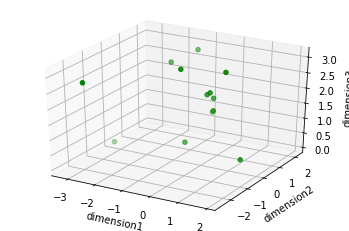

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')




ax.scatter(x,y,z, c='g', marker='o')

ax.set_xlabel('dimension1')
ax.set_ylabel('dimension2')
ax.set_zlabel('dimension3')

plt.show()

### No Evidence of Clustering!!

### Step 6: Using Deep Feedforward (DFF) Neural Networks on Keras Platform having backend TensorFlow, we apply Activation Function RELU and output functions SIGMOID and SOFTMAX. The optimizer is Steep Gradient Descept (SGD), loss functions are CATEGORICAL CROSSENTROPY and BINARY CROSSENTROPY while the metric is ACCURACY.

#### - Splitting Data Into Training and Testing Sets ... Later Cross Validation Will Be Used in Computing The Accuracy Score ...

In [17]:
SPLITS = dfSpark.randomSplit([0.8,0.2])

In [18]:
dfSpark_train = SPLITS[0]
dfSpark_test = SPLITS[1]

In [19]:
LENGTH

14

In [20]:
dfSpark_train.count()

243

In [21]:
import numpy as np

In [22]:
Xtrain = np.array(dfSpark_train.rdd.map(lambda x : x[0:-1]).collect())
Ytrain = np.array(dfSpark_train.rdd.map(lambda x : x[-1]).collect())
Xtest = np.array(dfSpark_test.rdd.map(lambda x : x[0:-1]).collect())
Ytest = np.array(dfSpark_test.rdd.map(lambda x : x[-1]).collect())

In [23]:
Xtrain.shape

(243, 13)

In [24]:
import numpy as np

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Dense, Dropout

from tensorflow.keras.utils import to_categorical


In [34]:
model = Sequential()

In [26]:
batch_size = 9
num_classes = 2
epochs = 10

In [223]:
Ytrain = to_categorical(Ytrain, num_classes)
Ytest = to_categorical(Ytest, num_classes)

#### Model DL1: Using Categorical CrossEntropy with Optimizer SGD and Accuracy Metric. Activation Function RELU and Output Function SOFTMAX

In [35]:
model.add(Dense(512, activation = 'relu', input_shape = (LENGTH-1,)))
model.add(Dropout (0.5))
model.add(Dense(num_classes, activation = 'softmax'))

In [36]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'sgd', metrics = ['accuracy']) 

In [37]:

model.fit(Xtrain, Ytrain, batch_size = batch_size, epochs = epochs, validation_data = (Xtest,Ytest)) 


Train on 243 samples, validate on 59 samples
Epoch 1/10
243/243 [==============================] - 12s 47ms/sample - loss: 0.6940 - acc: 0.5021 - val_loss: 0.5388 - val_acc: 0.7797
Epoch 2/10
243/243 [==============================] - 2s 10ms/sample - loss: 0.5685 - acc: 0.7407 - val_loss: 0.4612 - val_acc: 0.7966
Epoch 3/10
243/243 [==============================] - 3s 10ms/sample - loss: 0.5362 - acc: 0.7366 - val_loss: 0.4135 - val_acc: 0.8475
Epoch 4/10
243/243 [==============================] - 2s 9ms/sample - loss: 0.5025 - acc: 0.7613 - val_loss: 0.3814 - val_acc: 0.8814
Epoch 5/10
243/243 [==============================] - 15s 61ms/sample - loss: 0.4808 - acc: 0.7901 - val_loss: 0.3603 - val_acc: 0.8814
Epoch 6/10
243/243 [==============================] - 1s 3ms/sample - loss: 0.4685 - acc: 0.7695 - val_loss: 0.3446 - val_acc: 0.9153
Epoch 7/10
243/243 [==============================] - 1s 6ms/sample - loss: 0.4558 - acc: 0.7901 - val_loss: 0.3328 - val_acc: 0.8814
Epoch 8/10


In [38]:
score = model.evaluate(Xtest, Ytest, verbose = 0)

In [41]:
print("Loss Score = %.4f" % score[0])

Loss Score = 0.3157


In [42]:
print("Accuracy Score = %.4f" % score[1])

Accuracy Score = 0.8814


#### Model DL2: Using Binary CrossEntropy with Optimizer SGD and Accuracy Metric. Activation Function RELU and Output Function SIGMOID

In [44]:
batch_size = 9
num_classes = 1
epochs = 10

In [45]:
model.add(Dense(512, activation = 'relu', input_shape = (LENGTH-1,)))
model.add(Dropout (0.5))
model.add(Dense(num_classes, activation = 'sigmoid'))

In [46]:
model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy']) 

In [49]:
model.fit(Xtrain, Ytrain, batch_size = batch_size, epochs = epochs, validation_data = (Xtest,Ytest)) 


Train on 243 samples, validate on 59 samples
Epoch 1/10
243/243 [==============================] - 21s 88ms/sample - loss: 0.6874 - acc: 0.5556 - val_loss: 0.6993 - val_acc: 0.4915
Epoch 2/10
243/243 [==============================] - 9s 38ms/sample - loss: 0.6860 - acc: 0.5556 - val_loss: 0.6996 - val_acc: 0.4915
Epoch 3/10
243/243 [==============================] - 12s 51ms/sample - loss: 0.6890 - acc: 0.5556 - val_loss: 0.6996 - val_acc: 0.4915
Epoch 4/10
243/243 [==============================] - 27s 111ms/sample - loss: 0.6884 - acc: 0.5556 - val_loss: 0.6998 - val_acc: 0.4915
Epoch 5/10
243/243 [==============================] - 16s 67ms/sample - loss: 0.6888 - acc: 0.5556 - val_loss: 0.6997 - val_acc: 0.4915
Epoch 6/10
243/243 [==============================] - 16s 64ms/sample - loss: 0.6874 - acc: 0.5556 - val_loss: 0.7000 - val_acc: 0.4915
Epoch 7/10
243/243 [==============================] - 23s 94ms/sample - loss: 0.6859 - acc: 0.5556 - val_loss: 0.6998 - val_acc: 0.4915
Epo

In [50]:
score = model.evaluate(Xtest, Ytest, verbose = 0)

In [51]:
print("Loss Score = %.4f" % score[0])
print("Accuracy Score = %.4f" % score[1])

Loss Score = 0.7000
Accuracy Score = 0.4915
